In [1]:
if 'google.colab' in str(get_ipython()):
    import sys
    from google.colab import drive, output
    drive.mount('/content/drive')

    !pip install umap-learn
    !pip install umap-learn[plot]
    !pip install holoviews

    !pip install joypy
    # !pip install umap-learn
    output.clear()
    print("Running on colab")
    %load_ext autoreload
    %autoreload 1
    %cd '/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project'
    #sys.path.append('/content/drive/MyDrive/Deep Learning/AutoEncoders/Project/VQVAE_Working/data')
    #sys.path.append('/content/drive/MyDrive/Deep Learning/AutoEncoders/Project/VQVAE_Working/models')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Dataloader')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Models')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Modules')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Results/Results')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Results/Figures')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Result')
elif "zmqshell" in str(get_ipython()):
    print("Running on MIRP")
    root = "/home/mirp_ai/Documents/Daniel_Nieto/PhD/AutoEncoders_Ecoacoustics/Jaguas"
    root_path = "media/mirp_ai/Seagate Desktop Drive/Jaguas_2018"
else:
    import pathlib
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
    print("Running local")

Running on MIRP


In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import datetime
import gc
import pandas as pd
import joypy

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler as Normalizer

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torch.utils.data import random_split

import torchvision.datasets as datasets

from Jaguas_DataLoader_rainless import SoundscapeData
from Models import ConvAE as AE
from AE_training_functions import TestModel, TrainModel
from AE_Clustering import AE_Clustering 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from datetime import timedelta

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap

import random
def _set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).
 
    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
_set_seed(1024)

# AE Model

In [20]:
model_type = "AE"
identifier = "batch_size_14_num_hiddens_64_"
day = 11
hour = 21
month = 6
folder = "AE_No_rain_98"
date_format = f"day_{day}_hour_{hour}"

model_name = f"{root}/temporal/models/model_{model_type}_{identifier}_{date_format}_final.pth"
config = torch.load(f'temporal/configs/config_{model_type}_{identifier}_{date_format}.pth', map_location=torch.device('cpu'))
model = AE(num_hiddens=config["num_hiddens"]).to(device)
# dataset_test = torch.load(f'temporal/datasets/dataset_test_ae_jaguas_9_70%.pth')
# dataset_train = torch.load(f'temporal/datasets/dataset_train_ae_jaguas_9_70%.pth')
model.load_state_dict(torch.load(f'{model_name}', map_location=torch.device('cpu')))

y = torch.load(f"temporal/Features/{folder}/AE_labels_{date_format}_No_rain_Audios_Jaguas.pth",  map_location=torch.device('cpu'))
X = torch.load(f"temporal/Features/{folder}/AE_features_{date_format}_No_rain_Audios_Jaguas.pth",  map_location=torch.device('cpu'))
y_path = torch.load(f"temporal/Features/{folder}/AE_test_path_samples_{date_format}_No_rain_Audios_Jaguas.pth",  map_location=torch.device('cpu'))
path_flat = [item for sublist in y_path for item in sublist]
path_flat = np.asarray(path_flat)
print(X.shape)

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
Normalizer_ = Normalizer().fit(X)
X_norm = Normalizer_.transform(X)
PCA_ = PCA(n_components=60).fit(X_norm)
X_PCA = PCA_.transform(X_norm)
# X_TSNE = TSNE(n_components=2, learning_rate="auto", init='random', random_state=0).fit_transform(X_PCA)
reducer = umap.UMAP(min_dist=0.9, n_components=60)
X_UMAP = reducer.fit_transform(X_norm)
X_batch = np.reshape(X_UMAP, (X_UMAP.shape[0]//5,5,X_UMAP.shape[1]))
# X_UMAP_Norm = Normalizer().fit_transform(X_UMAP)


torch.Size([84820, 5184])


In [4]:
root_audios = f"{root}/Complementary_Files/Audios_Jaguas/Audios_Jaguas.csv"
root_recorders = f"{root}/Complementary_Files/df_grabadoras_reg.csv"
root_clusters = f"{root}/temporal/clusters"
root_ai = f"{root}/Complementary_Files/Acoustic_Indices/AI_Jaguas.csv"
root_vggish = f"{root}/vggish/Features_vggish"
ecological_integrity = f"{root}/Complementary_Files/Indice_Integridad_Ecologica.xlsx"

audios = pd.read_csv(root_audios, index_col=0)
recorders = pd.read_csv(root_recorders)
ei  = pd.read_excel(ecological_integrity)
ai = pd.read_csv(root_ai)
ai.drop(columns=["Unnamed: 0"], inplace=True)
ai.drop(columns=["Date"], inplace=True)
ai.dropna(inplace=True)

ai.set_index("file",inplace=True, drop=True)
audios.set_index("Filename", inplace=True)

## VGGISH Features and Labels

In [31]:
X_vgg = torch.load(f"{root_vggish}/vggish_features.pth")
y_vgg = torch.load(f"{root_vggish}/vggish_filenames.pth")

y_vgg2 = [i.split('/')[6] for i in y_vgg]
X_vgg2 = X_vgg
X_vgg3 = []
remove = []
remove_idx = []
keep_idx = []
for i in range(len(y_vgg2)):
    #a[i] = X_vgg2[i]
    if y_vgg2[i] not in y_3:
        remove.append(y_vgg2[i])
        remove_idx.append(X_vgg2[i])
    else:
        keep_idx.append(i)
for i in range(len(remove)): 
    y_vgg2.remove(remove[i])

for i in keep_idx:
    X_vgg3.append(X_vgg2[i])
    
X_vgg4 = np.zeros([16911,62,128])
for i in range (len(X_vgg3)):
    X_vgg4[i] = X_vgg3[i].numpy()
X_vgg4 = X_vgg4.reshape(X_vgg4.shape[0], X_vgg4.shape[1]*X_vgg4.shape[2])
    
labels = []
for i in range(len(y_vgg2)):
    labels.append(audios.loc[y_vgg2[i], "Habitat"])
    
from sklearn.model_selection import train_test_split
X_train, X_test, labels_train, labels_test = train_test_split(X_vgg4, labels, test_size=0.2,random_state=0)

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
clf_rf = RandomForestClassifier(max_depth=16, random_state=0, n_jobs=-1)
clf_rf.fit(X_train, labels_train)
y_pred_rf = clf_rf.predict(X_test)
accuracy = metrics.accuracy_score(labels_test, y_pred_rf)
f1_score = metrics.f1_score(labels_test, y_pred_rf, average="macro")
recall = metrics.recall_score(labels_test, y_pred_rf, average="macro")
print("Accuracy:", accuracy)
print("f1:", f1_score)
print("recall", recall)

Accuracy: 0.8459946792787467
f1: 0.7714564127766039
recall 0.7411086123604864


# Acoustic Indices Features and Labels

In [5]:
y_ = np.asarray(y_path)
y_2 = y_[:,0]
for i in range(len(y_2)):
    y_2[i] = y_2[i][0:-2] 
y_3 = list(y_2)

X_ai = []
remove = []
for i in range(len(y_3)):
    try:
        X_ai.append(ai.loc[y_3[i]])
#         print(i, " ", np.asarray(np.min(X_ai)))
    except:
        remove.append(y_3[i])
for i in range(len(remove)):
    y_3.remove(remove[i])
X_ai = np.asarray(X_ai)

labels_ai = []
# audios.set_index("Filename", inplace=True)
for i in range(len(y_3)):
    labels_ai.append(audios.loc[y_3[i], "Habitat"])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_ai, labels_ai, test_size=0.2,random_state=0)

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
clf_rf = RandomForestClassifier(max_depth=16, random_state=0, n_jobs=-1)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred_rf)
f1_score = metrics.f1_score(y_test, y_pred_rf, average="macro")
recall = metrics.recall_score(y_test, y_pred_rf, average="macro")
print("Accuracy:", accuracy)
print("f1:", f1_score)
print("recall", recall)

Accuracy: 0.8737806680461129
f1: 0.8195986374058009
recall 0.7905498415666719


# Autoencoders Features and Labels using independent segments

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split

# audios.set_index("Filename", inplace=True)
labels = []
for i in range(len(path_flat)):
    labels.append(audios.loc[path_flat[i][0:-2], "Habitat"])

X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=0.2,random_state=0)

# Autoencoders Features and Labels using 5 segments of the audio

In [ ]:
X_c = X_UMAP
y_c = list(path_flat)

# for i in range(len(y_c)):
#     split = y_c[i].split("_")[0:3]
#     y_c[i] = f"{split[0]}_{split[1]}_{split[2]}"
    
for i in range(len(remove)):
    for j in range(1,6):
        y_c.remove(f"{remove[i]}_{j}")
        X_c = np.delete(X_c, i, axis=0)
X_batch = np.reshape(X_c, (X_c.shape[0]//5,5,X_c.shape[1]))
y_c = np.asarray(y_c)
y_path = np.reshape(y_c, (y_c.shape[0]//5, 5))

In [21]:
from sklearn import svm
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_batch, y_path, test_size=0.2,random_state=0)

X_train = X_train.reshape(X_train.shape[0]*X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0]*X_test.shape[1], X_test.shape[2])
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
y_train = y_train.reshape(y_train.shape[0]*y_train.shape[1])
y_test = y_test.reshape(y_test.shape[0]*y_test.shape[1])

labels_train = []
for i in range(len(y_train)):
    labels_train.append(audios.loc[y_train[i][0:-2], "Habitat"])
labels_test = []
for i in range(len(y_test)):
    labels_test.append(audios.loc[y_test[i][0:-2], "Habitat"])
    

# Autoencoders Features and Labels using voting labels

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
clf_rf = RandomForestClassifier(max_depth=16, random_state=0, n_jobs=-1)
clf_rf.fit(X_train, labels_train)
y_pred_rf = clf_rf.predict(X_test)
accuracy = metrics.accuracy_score(labels_test, y_pred_rf)
f1_score = metrics.f1_score(labels_test, y_pred_rf, average="macro")
recall = metrics.recall_score(labels_test, y_pred_rf, average="macro")
print("Accuracy:", accuracy)
print("f1:", f1_score)
print("recall", recall)

Accuracy: 0.8459946792787467
f1: 0.7714564127766039
recall 0.7411086123604864


In [23]:
y_pred_rf2 = np.asarray(y_pred_rf)
y_pred_rf2 = np.reshape(y_pred_rf2,(y_pred_rf2.shape[0]//5,5))
y_test2 = np.asarray(labels_test)
y_test2 = np.reshape(y_test2,(y_test2.shape[0]//5,5))

def most_frequent(List):
    return max(set(List), key = List.count)

labels_test2 = []
labels_pred = []
for i in range(len(y_pred_rf2)):
    labels_pred.append(most_frequent(list(y_pred_rf2[i])))
    labels_test2.append(most_frequent(list(y_test2[i])))
accuracy = metrics.accuracy_score(labels_test2, labels_pred)
f1_score = metrics.f1_score(labels_test2, labels_pred, average="macro")
recall = metrics.recall_score(labels_test2, labels_pred, average="macro")

print("Accuracy:", accuracy)
print("f1:", f1_score)
print("recall", recall)


Accuracy: 0.9183613321544356
f1: 0.8932356241806185
recall 0.8828073622690342


In [ ]:
from sklearn.neural_network import MLPClassifier
clf_mlp = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(100), random_state=0)
clf_mlp.fit(X_train, y_train)
y_pred_mlp = clf_mlp.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_mlp))
print("f1:",metrics.f1_score(y_test, y_pred_mlp, average="macro"))

In [32]:
recalls

[0.7905498415666719,
 0.8868293769490232,
 0.8429372441078513,
 0.8828073622690342,
 0.7411086123604864]

In [28]:
# f1_scores = [] # [ai, AE_norm, AE_PCA, AE_UMAP, VGGISH, VGGISH_PCA, VGGISH_UMAP]
# accuracies = []
# recalls = []
UMAP_scores = []
UMAP_scores.append({"f1":f1_score, "acc": accuracy, "recall": recall})
f1_scores.append(f1_score)
accuracies.append(accuracy)
recalls.append(recall)

In [30]:
import pickle
with open("f1_scores_fair", "wb") as fp:   #Pickling
    pickle.dump(f1_scores, fp)
    
with open("accuracies_fair", "wb") as fp2:   #Pickling
    pickle.dump(accuracies, fp2)
    
with open("recalls_fair", "wb") as fp3:   #Pickling
    pickle.dump(recalls, fp3)

In [34]:
accuracy_scores = accuracy

([0.8195986374058009,
  0.9038930769510908,
  0.8697092169305058,
  0.8932356241806185,
  0.7714564127766039],
 [0.8737806680461129,
  0.9277925139994105,
  0.9056881815502505,
  0.9183613321544356,
  0.8459946792787467],
 [0.7905498415666719,
  0.8868293769490232,
  0.8429372441078513,
  0.8828073622690342,
  0.7411086123604864])

In [80]:
accuracy_scores

[0.8737806680461129,
 0.9277925139994105,
 0.9056881815502505,
 0.9183613321544356,
 0.8459946792787467]

In [77]:
f1_scores = pd.read_pickle(f"{root}/temporal/classification_results/f1_scores_fair")
accuracy_scores = pd.read_pickle(f"{root}/temporal/classification_results/accuracies_fair")
recall_scores = pd.read_pickle(f"{root}/temporal/classification_results/recalls_fair")

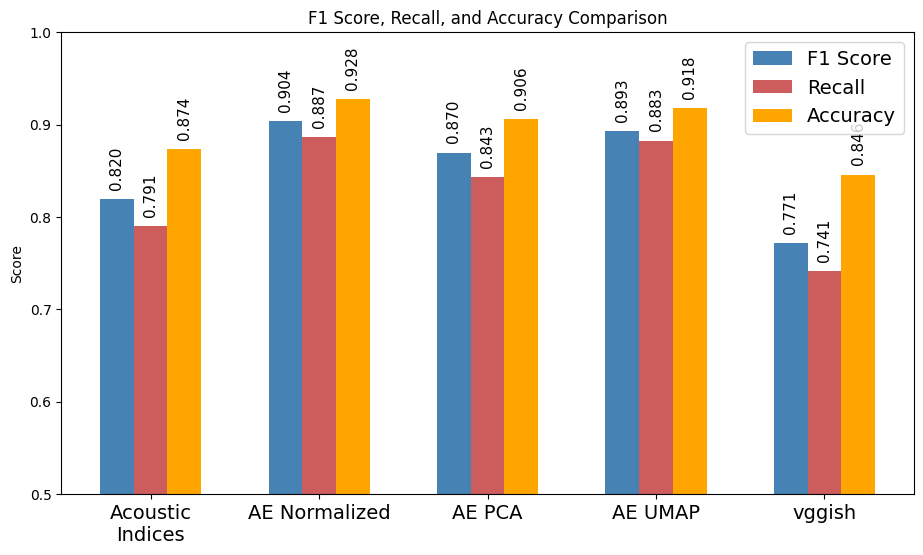

In [81]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for F1 scores, recall, and accuracy
methods = ["Acoustic\nIndices", "AE Normalized", "AE PCA", "AE UMAP", "vggish"]

# Create an array for the x-axis positions
x = np.arange(len(methods))

# Set the figure size
plt.figure(figsize=(11, 6))

# Width of the bars
bar_width = 0.2

# Define professional color palettes
f1_color = 'steelblue'  # You can adjust the color as needed
recall_color = 'indianred'  # You can adjust the color as needed
accuracy_color = 'orange'  # You can adjust the color as needed

# Create the bar chart for F1 scores
bars_f1 = plt.bar(x - bar_width, f1_scores, bar_width, label='F1 Score', color=f1_color)

# Create the bar chart for recall
bars_recall = plt.bar(x, recall_scores, bar_width, label='Recall', color=recall_color)

# Create the bar chart for accuracy
bars_accuracy = plt.bar(x + bar_width, accuracy_scores, bar_width, label='Accuracy', color=accuracy_color)

# Set the y-axis limits
plt.ylim(0.5, 1)

# Set the x-axis labels and their positions
plt.xticks(x, methods, fontsize=14)  # Increase label size

# Set the y-axis label
plt.ylabel('Score')

# Set the title
plt.title('F1 Score, Recall, and Accuracy Comparison')

# Set the legend with increased size
plt.legend(fontsize=14)  # Increase legend size

# Add values on top of the bars
for bar, value in zip(bars_f1, f1_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height()+0.01, f'{value:.3f}', ha='center', va='bottom', fontsize=11, rotation=90)

for bar, value in zip(bars_recall, recall_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height()+0.01, f'{value:.3f}', ha='center', va='bottom', fontsize=11, rotation=90)

for bar, value in zip(bars_accuracy, accuracy_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height()+0.01, f'{value:.3f}', ha='center', va='bottom', fontsize=11, rotation=90)

# Add a legend
# plt.legend()

# Display the figure
plt.show()
# plt.savefig(f"{root}/temporal/classification_results/calssification_fair_2.pdf", format="pdf")